# "Gillespie Algorithm"
> "In this blog post we will look at the grand-daddy of stochastic simulation methods: the Gillespie Algorithm (otherwise known as the stochastic simulation algorith SSA). If you have ever done any form of stochastic simulation you will owe a great deal of gratitude to the Gillespie algorithm which likely inspired the techniques you used."
- toc: true
- author: Lewis Cole (2020)
- branch: master
- badges: false
- comments: false
- categories: [Gillespie-Algorithm, Stochastic-Simulation-Algorithm, Computational-Statistics, Probability, Tau-Leaping, Master-Equation, Adaptive-Tau-Leaping]
- hide: false
- search_exclude: false
- image: https://github.com/lewiscoleblog/blog/raw/master/images/Gillespie/Gillespie.jpg

In [1]:
#hide
import warnings
warnings.filterwarnings('ignore')

The Gillespie algorithm is one of the most historically important stochastic simulation algorithms ever created. At its heart the intuition behind it is very simple and it is re-assuring that it "works" - this is not always the case with stochastic simulation where the "obvious" idea can sometimes have unintended debilitating consequences. 

The algorithm was first presented by Doob (and is sometimes refered to as the Doob-Gillespie algorithm) in the mid 1940s. It was implemented by Kendall in the 1950s. However it wasn't until the mid 1970s that Gillespie re-derived the method by studying physical systems that it became widely used. In publishing the method he essentially created the entire fields of systems biology and computational chemistry by opening the door to what is possible through stochastic simulation.

## Background
In this blog we will consider applying the Gillespie method to the area of chemical reaction kinetics, this is the application Gillespie originally had in mind. The concepts described will carry over to other applications.

Imagine we wish to model a particular chemical reaction. We could use a determistic approach to model the reaction, this will require setting up a family of coupled differential equations. In doing so we will essentially "ignore" any microscopic behaviour and look at the reaction system at a "high level". This can mean we miss out on a lot of the "detail" of the reaction which may be of interest to us. Further in some cases this approach may not even be applicable, for example to set up a differential equation we assume that we have large quantities of reactants that are perfectly mixed, this allows us to "average over" all reactants to create nice smooth dynamics. This may not reflect reality if there are only relatively few reactants in a system. An alternate approach is to use a stochastic "discrete event" model - this is where we model individual reactions seperately as discrete events occuring in time. This matches our physical intuition of how reactions occur: we wait until the reactants "bump" into each other in the right way before a reaction occurs. One way to summarise this mathematically is through the use of a "master equation". 

In the sciences a master equation represents the time evolution properties of a multi-state jumping system, by which we mean a system that "jumps" between distinct states through time (in contrast a "diffusion system" varies gradually). The system in question being stochastic in nature we are concerned with observing how the state distribution varies over time, for example: with some initial condition what is the probability of finding the system in a particular state within the next X seconds/minutes/years? Of course the time units depend on the nature of the system (e.g. if we construct a master equation for predator/prey dynamics we are unlikely to be interested in microsecond timescales, however if looking at a chemical reaction we are unlikely to find a timescale in days useful.) If we want to display the master equation mathematically we use a transition rate matrix $A(t)$ - this can evolve in time or it can be static. 

We can then express the master equation in the form:
$$ \frac{d\mathbf{P}_t}{dt} = A(t) \mathbf{P}_t $$
Where vector $\mathbf{P}_t$ represents the probability distribution of states at time t - obscured by notation is an initial condition. Those from a mathematical or probabilistic background will recognise this as a Kolmogorov backwards equation for jump processes. If we expand the notation a little such that $P_{ij}(s,t)$ represents the probability of the system being in state $i$ at time $s$ and state $j$ at time $t$ then we can note that the transition rate matrix satisfies:
\begin{align}
A_{ij}(t) &= \left[ \frac{\partial P_{ij}(t,u)}{du} \right]_{u=t} \\
A_{ij}(t) & \geq 0  \quad \quad \quad \quad \forall i \neq j \\
\sum_j A_{ij}(t) &= 0 \quad \quad \quad \quad \forall i
\end{align}
Further we can note that if there is a distribution $\pi$ such that:
$$ \pi_j A_{ij}(t) = \pi_i A_{ij}(t) $$
For all pairs of states $(i,j)$ then the process satisfies detailed balance and the process is a reversible Markov process.

## Gillespie Algorithm
The Gillespie algorithm is allows us to model the exact dynamics described by the master equation. In some (simple) cases we can solve the master equation analytically, but for complicated examples (e.g. say we have 50 different types of reaction occuring) this may not be feasible and so the Gillespie algorithm (or some sort of simulation method) is necessary. In pseudo code we can write down the Gillespie algorithm as:
1. **Initialization** - initialize the system, in the context of reaction kinetics this amounts to the setting up initial chemical concentrations
2. **Monte-Carlo** -
    1. Randomly simulate the time to the next event 
    2. Given an event has occurred randomly select which event has occured
3. **Update** - based on 2. move the model time forward to the event time and update the state of the system
4. **Repeat** - Iterate through steps 2. and 3. until some stopping criteria is met

This essentially follows our intuition and there is no "technical trickery" such as fancy sampling methods, acceptance/rejection, etc. It is just a clean simple method - which is nice! Since we model by event as opposed to discretizing time steps this is an "exact" simulation method - meaning any trajectory simulated will follow the master equation dynamics exactly. However due to the random nature of any trajectory we will have to loop over these steps multiple times to find "typical" reaction paths (or whatever property we are trying to study).

## An Example
To illustrate the algorithm in action we will take a simple reaction. We will have following forward reaction
$$A + B \to AB$$
Where two monomers $A$ and $B$ react to form a dimer $AB$. The corresponding reverse reaction being:
$$AB \to A + B$$
We will denote the rate of the forward reaction to be $r_f$ and the rate of the backward reaction to be $r_f$. If we let the number of molecules present be denoted by: $N_A, N_B$ and $N_{AB}$ then the rate of any reaction occurring is:
$$R = r_f N_A N_B + r_b N_{AB}$$
Also given a reaction has occured the probability of the forward reaction having taken place is:
$$\mathbb{P}(A + B \to AB) = \frac{r_f N_A N_B}{R}$$
For a model such as this we typically want to remove any "path dependence" - the arrival of the next reaction event is independent of reactions that have occurred previously (given the concentration of reactants). To satisfy this constraint typically reactions events are taken to follow a Poisson process. Under this assumption the number of reactions occuring within a time period $\Delta T$ follows a $Poisson(R\Delta T)$ distribution. Moreover the time between reactions is then follows an exponential distribution. Thus if we sample $u \sim U[0,1]$ then we take the time until next reaction to be $\tau = \frac{1}{R}ln\left( \frac{1}{u} \right)$. (Note: here I have used that $U$ and $(1-U)$ have the same distribution).

A basic implementation of this can be seen below:

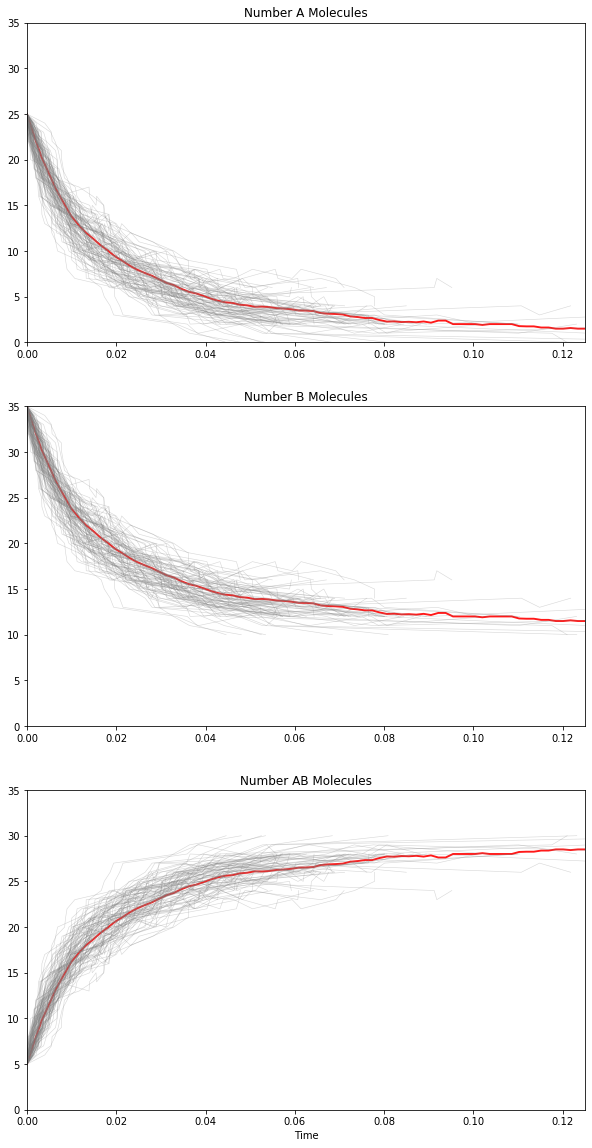

In [12]:
# An implenetation of the Gillespie algorithm
# applied to a pair of reactions:
# A + B -> AB
# AB -> A + B

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fix random seed for repeatability
np.random.seed(123)

###### Fix model parameters ######
N_A0 = 25     # Initial number of A molecules
N_B0 = 35     # Initial number of B molecules
N_AB0 = 5     # Initial number of AB molecules

rf = 2        # Forward reaction rate
rb = 1        # Backwards reaction rate

steps = 25    # Number of reactions per trajectory
cycles = 100  # Number of trajectories iterated over

# Set up holder arrays
T = np.zeros((cycles, steps+1))
N_A = np.zeros((cycles, steps+1))
N_B = np.zeros((cycles, steps+1))
N_AB = np.zeros((cycles, steps+1))

# Store initial conditions
N_A[:,0] = N_A0
N_B[:,0] = N_B0
N_AB[:,0] = N_AB0

###### Main Code Loop ######
for i in range(cycles):
    for j in range(steps):
        # Calculate updated overall reaction rate
        R = rf * N_A[i,j] * N_B[i,j] + rb * N_AB[i,j]
        
        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1/R * np.log(1/u1)
        
        # Store reaction time
        T[i, j+1] = T[i,j] + tau
        
        # Select which reaction to occur
        Rf = rf * N_A[i,j] * N_B[i,j] / R
        u2 = np.random.random()
        
        # Update populations
        if u2 < Rf:
            N_A[i,j+1] = N_A[i,j] - 1
            N_B[i,j+1] = N_B[i,j] - 1
            N_AB[i,j+1] = N_AB[i,j] + 1
        else:
            N_A[i,j+1] = N_A[i,j] + 1
            N_B[i,j+1] = N_B[i,j] + 1
            N_AB[i,j+1] = N_AB[i,j] - 1

# Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_A_ave = np.zeros(ave_steps+1)
N_B_ave = np.zeros(ave_steps+1)
N_AB_ave = np.zeros(ave_steps+1)

N_A_ave[0] = N_A0
N_B_ave[0] = N_B0
N_AB_ave[0] = N_AB0

# Pass over average array entries
for i in range(1, ave_steps+1):
    tmax = T_ave[i]
    A_sum = 0
    B_sum = 0
    AB_sum = 0
    t_count = 0
    
    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j,k] <= tmax and T[j,k+1] > tmax:
                t_count += 1
                A_sum += N_A[j,k]
                B_sum += N_B[j,k]
                AB_sum += N_AB[j,k]
    
    # Caclulate average - taking care if no samples observed
    if t_count == 0:
        N_A_ave[i] = N_A_ave[i-1]
        N_B_ave[i] = N_B_ave[i-1]
        N_AB_ave[i] = N_AB_ave[i-1]
    else:
        N_A_ave[i] = A_sum / t_count
        N_B_ave[i] = B_sum / t_count
        N_AB_ave[i] = AB_sum / t_count


###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

# Plot average trajectories
axs[0].plot(T_ave, N_A_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number A Molecules')
axs[0].set_ylim((0,35))
axs[0].set_xlim((0,0.125))
axs[1].plot(T_ave, N_B_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number B Molecules')
axs[1].set_ylim((0,35))
axs[1].set_xlim((0,0.125))
axs[2].plot(T_ave, N_AB_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number AB Molecules')
axs[2].set_xlabel("Time")
axs[2].set_ylim((0,35))
axs[2].set_xlim((0,0.125))

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(T[i,:], N_A[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(T[i,:], N_B[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(T[i,:], N_AB[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

In these plots we can see the various trajectories along with their average. If we increase the number of molecules and the number of trajectories we can get a "smoother" plot. Since we have the full evolution of the system we can also look at some other statistics, for example let's suppose we are interested in the distribution in the number of molecules of each type at time 0.5. We can also plot this using our samples:

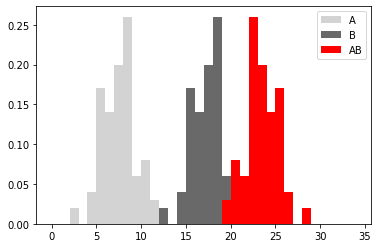

In [4]:
time = 0.025
N_A_time = np.zeros(cycles)
N_B_time = np.zeros(cycles)
N_AB_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if T[i,j] => time and T[i,j-1] < time:
            N_A_time[i] = N_A[i,j]
            N_B_time[i] = N_B[i,j]
            N_AB_time[i] = N_AB[i,j]
    # If trajectory doesn't span far enough take latest observation
    if T[i, steps] < time:
        N_A_time[i] = N_A[i, steps]
        N_B_time[i] = N_B[i, steps]
        N_AB_time[i] = N_AB[i, steps]

plt.hist(N_A_time, density=True, bins=np.arange(35), label="A", color='lightgrey')
plt.hist(N_B_time, density=True, bins=np.arange(35), label="B", color='dimgrey')
plt.hist(N_AB_time, density=True, bins=np.arange(35), label="AB", color='red')
plt.legend()
plt.show()

If instead of a system of 2 reactions we instead wanted to look a system of a large number of reactions we could modify the method above quite simply. Instead of the calculation of $R$ (overall reaction rate) consisting of 2 terms it will consist of a larger number of terms depending on the nature of the individual reactions. The probability of selecting a particular reaction type would then equally be in proportion to their contribution to $R$. 

We can also notice that there is nothing "special" about the method that means it only applies to reaction kinetics. For example: the example code above could equally be a "marriage and divorce model" for heterosexual couples: A representing women and B representing men, AB representing a marriage. Through defining the "reactions" slightly differently it doesn't take much modification to turn this into a infection model: for example there could be 3 states: susceptible to infection, infected and recovered (potentially with immunity) with transition rates between each of these states.

We can see then that the Gillespie algorithm is very flexible and allows us to model stochastic systems that may otherwise be mathematically intractable. Through the nature of the modelling procedure we can sample from the system exactly (upto the precision of floating point numbers within our computers!)

There is a downside to exact simulation however: it can be very slow! In the example above the speed isn't really an issue since the system is so simple. However if we were modelling many different reaction types (say the order of 100s) then to allow for adequate samples we will need to run many trajectories, this can quickly spiral into a very slow running code! Thankfully however the method has been adapted in many ways to combat this issue.

## Hybrid-Gillespie
We can note that calculating deterministic results from an ODE is (much) quicker than implementing the Gillespie simulation algorithm since there is no random element. However we notice that we do not have to model every reaction type using the same Gillespie approach. For example suppose we have one reaction type that is much slower than the others, say the order of 10 times slower. We could model this reaction via a determinstic ODE approach and simply rely on Gillespie for the more rapidly changing dynamics. Of course this is not applicable in every situation - as with any modelling or approximation used we should be sure that it is applicable to the situation at hand. For brevity we will not code an example of this here but it should be easy enough to modify the code above (for example by adding that molecule $A$ can "disappear" from the system with a rate 1/10 times the rate of the backward reaction).

## Tau Leaping
Tau leaping modifies the Gillespie methodology above, it sacrifices exact simulation in favour of an approximate simulation that is quicker to compute. The main idea behind tau-leaping is also intuitive: instead of modelling time to the next event we "jump" forward in time and then compute how many reactions we would expect to see within that time frame and updating the population amounts in one step. By updating the population amounts in one go we should be able to compute much faster. It should be clear that this is an approximation to the Gillespie algorithm. The size of the "leaps" determines how efficient the method is and how accurate the approximation is. If we make very large steps we can model many reactions per step which speeds up the implementation, however the simulation will also be less accurate since the populations will be updated less frequently. Conversely a very small leap size will mean many leaps will not see a reaction and so the algorithm will run more slowly, however this should result in dynamics very close to the Gillespie method. Often choosing the leap size requuires some trial and error.

we can write pseudo-code for the tau-leaping process as:
1. **Initialize** - Set initial conditions for the system and set leaping size
2. **Calculate event rates** - for each event types depending on state of the system
3. **Monte-Carlo** - for each event type sample number of events occuring within the leap
4. **Update** - Update system state based on number of events
5. **Repeat** - Repeat steps 2-4 until some stopping criteria is met

Recall: in the example above we used an exponential waiting time between reactions. This means the reactions occur as a poisson process - as a result the number of reactions occuring within a given timeframe will follow a poisson distribution. We also have to be careful to not allow a negative population (at least in the example presented - in other systems this may be reasonable).

We can modify our example above to use Tau-leaping as:

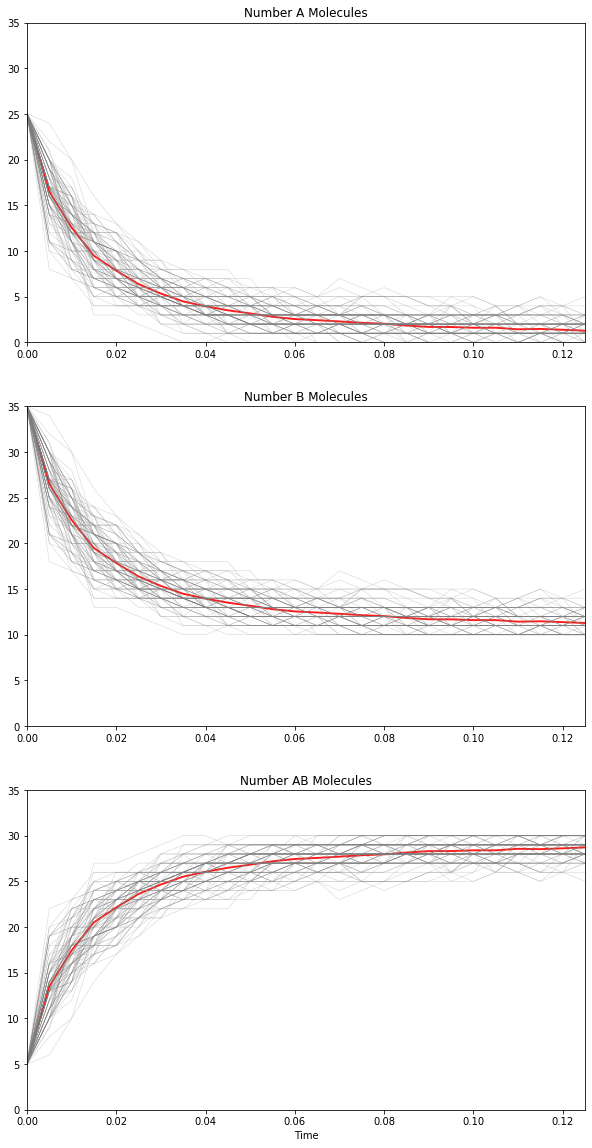

In [15]:
# An implenetation of the Gillespie algorithm
# with tau leaping
# Applied to a pair of reactions:
# A + B -> AB
# AB -> A + B

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
%matplotlib inline

# Fix random seed for repeatability
np.random.seed(123)

###### Fix model parameters ######
N_A0 = 25     # Initial number of A molecules
N_B0 = 35     # Initial number of B molecules
N_AB0 = 5     # Initial number of AB molecules

rf = 2        # Forward reaction rate
rb = 1        # Backwards reaction rate

leap = 0.005 # Size of leaping steps

steps = 25    # Number of leaps per trajectory
cycles = 100  # Number of trajectories iterated over

# Set up holder arrays
T = np.arange(steps+1)*leap
N_A = np.zeros((cycles, steps+1))
N_B = np.zeros((cycles, steps+1))
N_AB = np.zeros((cycles, steps+1))

# Store initial conditions
N_A[:,0] = N_A0
N_B[:,0] = N_B0
N_AB[:,0] = N_AB0

###### Main Code Loop ######
for i in range(cycles):
    for j in range(steps):
        # Calculate updated reaction rates
        Rf = rf * N_A[i,j] * N_B[i,j] 
        Rb = rb * N_AB[i,j]
        
        # Calculate number of reactions by type
        uf = np.random.random()
        ub = np.random.random()
        
        Nf = poisson.ppf(uf, Rf*leap)
        Nb = poisson.ppf(ub, Rb*leap)
        
        # Apply limits to prevent negative population
        Limitf = min(N_A[i,j], N_B[i,j])
        Limitb = N_AB[i,j]
        
        Nf = min(Nf, Limitf)
        Nb = min(Nb, Limitb)
        
        # Update populations
        N_A[i,j+1] = N_A[i,j] + Nb - Nf
        N_B[i,j+1] = N_B[i,j] + Nb - Nf
        N_AB[i,j+1] = N_AB[i,j] + Nf - Nb

# Calculate average arrays
N_A_ave = N_A.mean(axis=0)
N_B_ave = N_B.mean(axis=0)
N_AB_ave = N_AB.mean(axis=0)

###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

# Plot average trajectories
axs[0].plot(T, N_A_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number A Molecules')
axs[0].set_ylim((0,35))
axs[0].set_xlim((0,0.125))
axs[1].plot(T, N_B_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number B Molecules')
axs[1].set_ylim((0,35))
axs[1].set_xlim((0,0.125))
axs[2].plot(T, N_AB_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number AB Molecules')
axs[2].set_xlabel("Time")
axs[2].set_ylim((0,35))
axs[2].set_xlim((0,0.125))

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(T[:], N_A[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(T[:], N_B[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(T[:], N_AB[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

We can see here that even though the trajectories from tau-leaping are less exact the procedure has produced smoother average results for the same number of simulation steps (approximately the same running time).

And again we can look at the distribution at time=0.025:

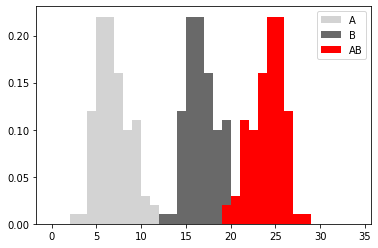

In [24]:
time = 0.025
N_A_time = np.zeros(cycles)
N_B_time = np.zeros(cycles)
N_AB_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if T[j] >= time and T[j-1] < time:
            N_A_time[i] = N_A[i,j]
            N_B_time[i] = N_B[i,j]
            N_AB_time[i] = N_AB[i,j]
    # If trajectory doesn't span far enough take latest observation
    if T[i, steps] < time:
        N_A_time[i] = N_A[i, steps]
        N_B_time[i] = N_B[i, steps]
        N_AB_time[i] = N_AB[i, steps]

plt.hist(N_A_time, density=True, bins=np.arange(35), label="A", color='lightgrey')
plt.hist(N_B_time, density=True, bins=np.arange(35), label="B", color='dimgrey')
plt.hist(N_AB_time, density=True, bins=np.arange(35), label="AB", color='red')
plt.legend()
plt.show()

Here we can see improved distributions with (what appears to be) less noise. To justify this we would want to run more tests however.

Note: this is the most basic implementation of the tau-leaping procedure. In certain situations this needs to be manipulated to improve behaviour, for example if the poisson draw is often large enough to cause the population to go negative then a truncation procedure (or acceptance/rejection scheme) needs to be employed in such a way as to retain the average reaction rates. In this simple example we ignore this complication, there are some occasions where the number of $A$ molecules hits zero so there will be some bias in the estimates presented above.

## Adaptive Tau-Leaping
The "problem" with the tau-leaping method above is that it is very sensitive to the leap size. It is also possible that as the system evolves what started out as a "good" leap size becomes "bad" as the dynamics change. One possible solution to this is to use an "adaptive" method whereby the leap size varies depending on the dynamics. The main idea is to limit the leap sizes from being so large that the populations can reach an unfavourable state (e.g. negative population sizes) or jump to a state "too far away".

There are many ways to do this, one of the more popular was developed by Y. Cao and D. Gillespie in 2006. In order to describe the method we will need to introduce some notation. We let $\mathbf{X}_t = \left( X_t^i \right)_{i=1}^N$ to be a vector of population sizes at time t. We intorduce variables $v_{ij}$ to represent the change in component $i$ of the population when an event $j$ occurs - we will use $i$ indices to refer to components of the population vector and $j$ indices to refer to event types. $R_j(\mathbf{X}_t)$ is the rate of event $j$ with population $\mathbf{X}_t$. In this method we look to bound the relative shift in rates at each step by a parameter $\epsilon$.

In pseudo-code we can describe the process via:
1. **Initialize** - Set initial conditions for the population
2. **Calculate event rates** - $R_j$ for each event types depending on state of the system
3. **Calculate auxiliary variables** - for each state component $i$
\begin{align}
\mu_i &= \sum_j v_{ij} R_j \\
\sigma_j^2 &= \sum_j v_{ij}^2 R_j
\end{align}
4. **Select highest order event** - for each state component $i$, denote the rate of this event as $g_i$
5. **Calculate time step**
$$ \tau = min_i \left( min\left( \frac{max\left( \frac{\epsilon X_i}{g_i}, 1 \right)}{|\mu_i|} , \frac{max\left( \frac{\epsilon X_i}{g_i}, 1 \right)^2}{\sigma_j^2} \right) \right) $$
6. **Monte-Carlo** - for each event type sample number of events occuring within the leap step $\tau$
7. **Update** - Update system state based on number of events
8. **Repeat** - Repeat steps 2-7 until some stopping criteria is met

Step 4. involves selecting the highest order event - this essentially is the "most important" event that each $i$ is involved in. For very complex systems this may not be an obvious thing to do and will require more finesse. We can see that aside from steps 3-5 this is the exact same scheme as the previous example.

There are other adaptive leaping schemes that one could use each with different pros and cons.

We can modify the code above to use this scheme via:

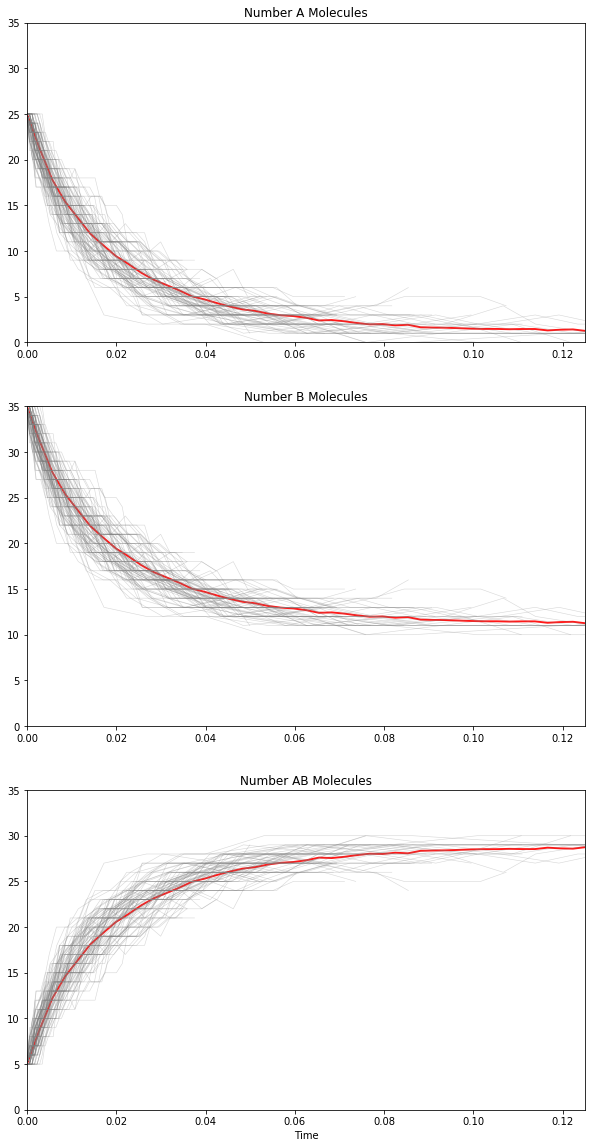

In [17]:
# An implenetation of the Gillespie algorithm
# With adaptive tau-leaping
# Applied to a pair of reactions:
# A + B -> AB
# AB -> A + B

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
%matplotlib inline

# Fix random seed for repeatability
np.random.seed(123)

###### Fix model parameters ######
N_A0 = 25     # Initial number of A molecules
N_B0 = 35     # Initial number of B molecules
N_AB0 = 5     # Initial number of AB molecules

rf = 2        # Forward reaction rate
rb = 1        # Backwards reaction rate

eps = 0.03    # Epsilon adaptive rate

steps = 25    # Number of reactions per trajectory
cycles = 100  # Number of trajectories iterated over

# Set up holder arrays
T = np.zeros((cycles, steps+1))
N_A = np.zeros((cycles, steps+1))
N_B = np.zeros((cycles, steps+1))
N_AB = np.zeros((cycles, steps+1))

# Store initial conditions
N_A[:,0] = N_A0
N_B[:,0] = N_B0
N_AB[:,0] = N_AB0

###### Main Code Loop ######
for i in range(cycles):
    for j in range(steps):
        # Calculate updated reaction rates
        Rf = rf * N_A[i,j] * N_B[i,j] 
        Rb = rb * N_AB[i,j]
        
        # Calculate auxiliary variables
        mu_A = Rf - Rb
        mu_B = Rf - Rb
        mu_AB = Rb - Rf
        
        sig2_A = Rf + Rb
        sig2_B = Rf + Rb
        sig2_AB = Rf + Rb
        
        # Select highest order reactions
        g_A = Rf
        g_B = Rf
        g_AB = Rb
        
        # Caclulate internal maxima - taking care of divide by zero
        if g_A == 0:
            max_A = 1
        else:
            max_A = max(eps*N_A[i,j]/g_A,1)
        
        if g_B == 0:
            max_B = 1
        else:
            max_B = max(eps*N_B[i,j]/g_B, 1)
        
        if g_AB == 0:
            max_AB = 1
        else:
            max_AB = max(eps*N_AB[i,j]/g_AB, 1)
         
        # Calculate minima for each component
        min_A = min(max_A / abs(mu_A), max_A**2 / sig2_A)
        min_B = min(max_B / abs(mu_B), max_B**2 / sig2_B)
        min_AB = min(max_AB / abs(mu_AB), max_AB**2 / sig2_AB)
        
        # Select tau leap size
        leap = min(min_A, min_B, min_AB)
        
        # Calculate number of reactions by type
        uf = np.random.random()
        ub = np.random.random()
        
        Nf = poisson.ppf(uf, Rf*leap)
        Nb = poisson.ppf(ub, Rb*leap)
        
        # Apply limits to prevent negative population
        Limitf = min(N_A[i,j], N_B[i,j])
        Limitb = N_AB[i,j]
        
        Nf = min(Nf, Limitf)
        Nb = min(Nb, Limitb)
        
        # Update populations and times
        N_A[i,j+1] = N_A[i,j] + Nb - Nf
        N_B[i,j+1] = N_B[i,j] + Nb - Nf
        N_AB[i,j+1] = N_AB[i,j] + Nf - Nb
        T[i,j+1] = T[i,j] + leap

# Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average array holders
T_ave = np.linspace(0,T_max,ave_steps+1)
N_A_ave = np.zeros(ave_steps+1)
N_B_ave = np.zeros(ave_steps+1)
N_AB_ave = np.zeros(ave_steps+1)

N_A_ave[0] = N_A0
N_B_ave[0] = N_B0
N_AB_ave[0] = N_AB0

# Pass over average array entries
for i in range(1, ave_steps+1):
    tmax = T_ave[i]
    A_sum = 0
    B_sum = 0
    AB_sum = 0
    t_count = 0
    
    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j,k] <= tmax and T[j,k+1] > tmax:
                t_count += 1
                A_sum += N_A[j,k]
                B_sum += N_B[j,k]
                AB_sum += N_AB[j,k]
    
    # Caclulate average - taking care if no samples observed
    if t_count == 0:
        N_A_ave[i] = N_A_ave[i-1]
        N_B_ave[i] = N_B_ave[i-1]
        N_AB_ave[i] = N_AB_ave[i-1]
    else:
        N_A_ave[i] = A_sum / t_count
        N_B_ave[i] = B_sum / t_count
        N_AB_ave[i] = AB_sum / t_count


###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

axs[0].plot(T_ave, N_A_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number A Molecules')
axs[0].set_ylim((0,35))
axs[0].set_xlim((0,0.125))
axs[1].plot(T_ave, N_B_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number B Molecules')
axs[1].set_ylim((0,35))
axs[1].set_xlim((0,0.125))
axs[2].plot(T_ave, N_AB_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number AB Molecules')
axs[2].set_xlabel("Time")
axs[2].set_ylim((0,35))
axs[2].set_xlim((0,0.125))

for i in range(cycles):
    axs[0].plot(T[i,:], N_A[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(T[i,:], N_B[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(T[i,:], N_AB[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

As with the previous tau-leaping algorithm there the trajectories are noticably less exact than the original Gillespie formulation. However owing to the variable time step the trajectories do appear slightly less granular than in the previous tau-leaping formulation. Again the average trajectory is smoother than in the original method for (approximately) the same amount of run-time.

Looking at the time=0.025 distributions once again:

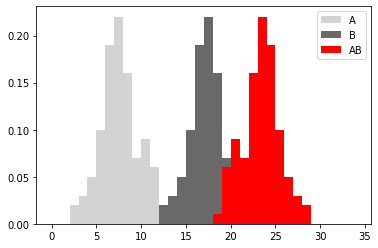

In [18]:
time = 0.025
N_A_time = np.zeros(cycles)
N_B_time = np.zeros(cycles)
N_AB_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps+1):
        if T[i,j] >= time and T[i,j-1] < time:
            N_A_time[i] = N_A[i,j]
            N_B_time[i] = N_B[i,j]
            N_AB_time[i] = N_AB[i,j]
    if T[i, steps] < time:
        N_A_time[i] = N_A[i, steps]
        N_B_time[i] = N_B[i, steps]
        N_AB_time[i] = N_AB[i, steps]

plt.hist(N_A_time, density=True, bins=np.arange(35), label="A", color='lightgrey')
plt.hist(N_B_time, density=True, bins=np.arange(35), label="B", color='dimgrey')
plt.hist(N_AB_time, density=True, bins=np.arange(35), label="AB", color='red')
plt.legend()
plt.show()

Again the distributions for a fixed time appear to have become less noisy.

In a small scale simple example such as this we would expect any "improvements" from a scheme like this to be minor, as we run more complicated examples we would expect a bigger performance differential.

## Conclusion
In this blog post we have seen 3 variations of the Gillespie algorithm: the original, tau-leaping and an adaptive tau leaping scheme. We have seen that the original variation produces exact simulations of a specified system, via tau leaping we have seen that we can approximate this and still get reasonable results in a quicker time. Which is important when dealing with more complicated and larger systems.

At this point we should also see the flexibility inherent in the Gillespie framework and why it has been applied in many different areas. We can also see that the algorithm is a "gateway" into agent-based schemes - instead of using a purely stochastic mechanism for selecting reaction types/times we could (for example) model individual molecules moving around in space and if they come within a certain radius of each other at a certain speed then a reaction occurs. This would turn the Gillespie algorithm into a full agent-based model for reaction kinetics (the benefit of doing this in most situations is likely slim to none however).